# Feature Engineering

In [121]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from ml2_mlsupervisadoavanzado.eee.feature_enginering import FeatureEngineeringProcessor

In [122]:
# Dataset Hotel Booking -> https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data
raw_data = pd.read_csv("../data/raw/hotel_bookings.csv")

In [123]:
# Divide el DataFrame en conjuntos de entrenamiento y prueba usando scikit-learn.
train_raw_data, test_raw_data = train_test_split(
    raw_data, test_size=0.2, random_state=42
)

In [124]:
train_processor = FeatureEngineeringProcessor(
    raw_data=train_raw_data,
    pipeline_name="train_pipeline"
)
# Ejecuta el procesamiento de características.
train_processor.run()

# Guarda la tabla de características en disco.
train_processor.write_feature_table("../ml2_mlsupervisadoavanzado/eee/data/bookings_feature_table")

2025-08-04 14:27:53.629 | INFO     | ml2_mlsupervisadoavanzado.eee.feature_enginering:run:68 - Inicializando pipeline train_pipeline
2025-08-04 14:27:53.629 | INFO     | ml2_mlsupervisadoavanzado.eee.feature_enginering:encode_categoricals:51 - Codificando con OHE hotel
2025-08-04 14:27:53.652 | INFO     | ml2_mlsupervisadoavanzado.eee.feature_enginering:encode_categoricals:51 - Codificando con OHE market_segment
2025-08-04 14:27:53.670 | INFO     | ml2_mlsupervisadoavanzado.eee.feature_enginering:encode_categoricals:51 - Codificando con OHE reserved_room_type
2025-08-04 14:27:55.487 | INFO     | ml2_mlsupervisadoavanzado.eee.feature_enginering:write_feature_table:108 - Escribiendo feature table en ../ml2_mlsupervisadoavanzado/eee/data/bookings_feature_table


In [126]:
df_parquet = pd.read_parquet("../ml2_mlsupervisadoavanzado/eee/data/bookings_feature_table.parquet")
df_parquet[["booking_id", "event_timestamp", "created", "great_feature1", "great_feature2"]].head()

,booking_id,event_timestamp,created,great_feature1,great_feature2
0,76c5a6aa-f7e1-4957-a6d3-db9f2307a7e7,2025-08-04 14:27:54.258511,2025-08-04 14:27:55.374306,2.169662,0.890985
1,0246660c-ead1-4f0d-ad4a-0bdf4092a315,2025-08-04 14:27:54.258514,2025-08-04 14:27:55.374310,2.309743,-0.817679
2,d3236ae9-d77c-40e8-8922-91a5703ac13a,2025-08-04 14:27:54.258515,2025-08-04 14:27:55.374311,5.391121,-1.749610
3,f01bb250-8087-4614-99b8-207a47c94dde,2025-08-04 14:27:54.258515,2025-08-04 14:27:55.374311,-0.049387,1.275659
4,56233e0f-9ae2-4946-90d4-3bf63eaad781,2025-08-04 14:27:54.258515,2025-08-04 14:27:55.374311,-0.626450,-0.132513


# Consumir features

In [127]:
from feast import FeatureStore
from feast import FileSource, Entity, FeatureView, ValueType, Field
from feast.types import Float64

# Define una entidad para los clientes.
customer_entity = Entity(
    name="customer_id",
    value_type=ValueType.STRING,
    join_keys=["booking_id"],
    description="ID del booking del cliente",
)
## Define una nueva fuente de datos
#customer_source = FileSource(
    #name="customer_source",
    #path="../../ml2_mlsupervisadoavanzado/eee/data/bookings_feature_table.parquet",
    #timestamp_field="event_timestamp",
#)
# Define una vista de características para los clientes.
customer_view = FeatureView(
    name="customer_view",
    entities=[customer_entity],
    source=FileSource(
        name="customer_source",
        path="../../ml2_mlsupervisadoavanzado/eee/data/bookings_feature_table.parquet",
        timestamp_field="event_timestamp",
    ),
    schema=[
        Field(name="great_feature1", dtype=Float64, description="This is a great feature"),
        Field(name="great_feature2", dtype=Float64, description="This is a great feature"),
    ],
    # ttl=None,  # No se aplica TTL para este ejemplo.
    online=True,
)

# Crea un FeatureStore para consumir las características.
fs = FeatureStore("../feature_repo/feature_repo")
# Registra la entidad y la vista de características en el FeatureStore.
fs.apply([customer_entity, customer_view])

In [79]:
## Carga las características de la vista de clientes.
#features = fs.get_online_features(
    #features=["customer_view:great_feature1", "customer_view:great_feature2"],
    ## entity_rows=[{"customer_id": 1}, {"customer_id": 2}],
    #entity_rows= [{"customer_id": i} for i in pd.read_parquet("../ml2_mlsupervisadoavanzado/eee/data/bookings_feature_table.parquet")["booking_id"][:1].tolist()]
#).to_dict()
## Imprime las características obtenidas.
#print(features)

In [128]:
entity_df_offline = pd.DataFrame.from_dict(
        {
            # IDs de reservas para consultar features.
            # "customer_id": ["f1ccaa85-7747-4dc3-be4d-5f229a2e07a4", "1466b87e-16c3-484e-b122-c0de8f375e0e"],
            "booking_id": pd.read_parquet("../ml2_mlsupervisadoavanzado/eee/data/bookings_feature_table.parquet")["booking_id"][:1000].tolist(),
        },
    )

entity_df_offline["event_timestamp"] = pd.to_datetime("now", utc=True)
entity_df_offline

,booking_id,event_timestamp
0,76c5a6aa-f7e1-4957-a6d3-db9f2307a7e7,2025-08-04 19:28:56.157803+00:00
1,0246660c-ead1-4f0d-ad4a-0bdf4092a315,2025-08-04 19:28:56.157803+00:00
2,d3236ae9-d77c-40e8-8922-91a5703ac13a,2025-08-04 19:28:56.157803+00:00
3,f01bb250-8087-4614-99b8-207a47c94dde,2025-08-04 19:28:56.157803+00:00
4,56233e0f-9ae2-4946-90d4-3bf63eaad781,2025-08-04 19:28:56.157803+00:00
...,...,...
995,44f87017-b43a-4668-8503-e886fb212519,2025-08-04 19:28:56.157803+00:00
996,4e9bb413-41b3-42c4-b7b3-b33ab13f6e59,2025-08-04 19:28:56.157803+00:00
997,975178fa-5501-41b5-8c9c-4b993a177dfb,2025-08-04 19:28:56.157803+00:00
998,db33ebdd-39e1-4e16-858d-e4a37bd16679,2025-08-04 19:28:56.157803+00:00


In [129]:
feature_table = fs.get_historical_features(
    # Consulta las features históricas en Feast usando los valores del DataFrame.
    entity_df=entity_df_offline,
    features=[
        # Solicita las features 'great_feature1' y 'great_feature2' de la vista 'pc_booking_view',
        "customer_view:great_feature1",
        "customer_view:great_feature2",
    ],
# Convierte el resultado a un DataFrame de pandas.
).to_df()
feature_table.head()

,booking_id,event_timestamp,great_feature1,great_feature2
0,76c5a6aa-f7e1-4957-a6d3-db9f2307a7e7,2025-08-04 19:28:56.157803+00:00,2.169662,0.890985
1,0246660c-ead1-4f0d-ad4a-0bdf4092a315,2025-08-04 19:28:56.157803+00:00,2.309743,-0.817679
2,d3236ae9-d77c-40e8-8922-91a5703ac13a,2025-08-04 19:28:56.157803+00:00,5.391121,-1.749610
3,f01bb250-8087-4614-99b8-207a47c94dde,2025-08-04 19:28:56.157803+00:00,-0.049387,1.275659
4,56233e0f-9ae2-4946-90d4-3bf63eaad781,2025-08-04 19:28:56.157803+00:00,-0.626450,-0.132513


# Preprocesamiento

In [131]:
import random
# Simula una columna de objetivo binario para el DataFrame de características.
# Esto es solo para propósitos de demostración y no representa un objetivo real.
feature_table["target"] = [random.choice([0,1]) for i in range(1000)]
feature_table.head()

,booking_id,event_timestamp,great_feature1,great_feature2,target
0,76c5a6aa-f7e1-4957-a6d3-db9f2307a7e7,2025-08-04 19:28:56.157803+00:00,2.169662,0.890985,1
1,0246660c-ead1-4f0d-ad4a-0bdf4092a315,2025-08-04 19:28:56.157803+00:00,2.309743,-0.817679,0
2,d3236ae9-d77c-40e8-8922-91a5703ac13a,2025-08-04 19:28:56.157803+00:00,5.391121,-1.749610,1
3,f01bb250-8087-4614-99b8-207a47c94dde,2025-08-04 19:28:56.157803+00:00,-0.049387,1.275659,0
4,56233e0f-9ae2-4946-90d4-3bf63eaad781,2025-08-04 19:28:56.157803+00:00,-0.626450,-0.132513,0


In [132]:
X, y = feature_table.drop(columns=["booking_id", "event_timestamp", "target"]), feature_table["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
X_train.head(), y_train.head()  # Muestra las primeras filas de X_train e y_train para verificar el preprocesamiento.

(     great_feature1  great_feature2
 29         5.524526        0.040074
 535       -0.754964       -0.595458
 695        1.386864        2.549544
 557       -0.444625        1.452353
 836       -0.264768        1.419504,
 29     1
 535    0
 695    0
 557    0
 836    1
 Name: target, dtype: int64)

# MLFlow

In [85]:
import mlflow
import dagshub

# Inicializa la integración con DagsHub, especificando el propietario y nombre del repositorio,
# y habilita la integración con MLflow para registrar experimentos en DagsHub
dagshub.init(
  repo_owner='edynsoncoronado',
  repo_name='ml_supervisado_avanzado',
  mlflow=True
)

Initialized MLflow to track repo "edynsoncoronado/ml_supervisado_avanzado"

Repository edynsoncoronado/ml_supervisado_avanzado initialized!

In [86]:
mlflow.set_tracking_uri("https://dagshub.com/edynsoncoronado/ml_supervisado_avanzado.mlflow")

name_experiment = "MLSupervisadoavanzado + MLFlow + Feast"
# mlflow.create_experiment(name_experiment)
mlflow.set_experiment(name_experiment)

<Experiment: artifact_location='mlflow-artifacts:/cd779af4798d4005a6e6408ada59fecf', creation_time=1754329033951, experiment_id='3', last_update_time=1754329033951, lifecycle_stage='active', name='MLSupervisadoavanzado + MLFlow + Feast', tags={}>

## MLSupervisado

In [87]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

# Activa el registro automático de parámetros, métricas y artefactos de modelos compatibles con MLflow
mlflow.autolog()

# Inicia una nueva ejecución de MLflow con el nombre especificado
with mlflow.start_run(run_name="Baseline - Dummy Classifier - Con métricas") as run:

    # Crea una instancia del clasificador Dummy usando la estrategia "most_frequent"
    algorithm = DummyClassifier(strategy="most_frequent")
    # Ajusta el clasificador Dummy con los datos de entrenamiento
    algorithm.fit(X_train, y_train)

    # Realiza predicciones sobre el conjunto de prueba
    predictions = algorithm.predict(X_test)

    # Calcula la métrica de exactitud (accuracy) usando las etiquetas verdaderas y las predichas
    _accuracy_score = accuracy_score(y_test, predictions)
    # Calcula la métrica F1 usando las etiquetas verdaderas y las predichas
    _f1_score = f1_score(y_test, predictions)
    
    # Registra las métricas calculadas en MLflow
    mlflow.log_metrics(
        {
            "accuracy": _accuracy_score,
            "f1": _f1_score
        }
    )

2025/08/04 14:12:25 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/08/04 14:12:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/08/04 14:12:25 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/04 14:12:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/04 14:12:25 WARNING mlflow.utils.autologging_utils: MLflow transformers autologging is known to be compatible with 4.35.2 <= transformers <= 4.51.2, but the installed version is 4.53.2. If you encounter errors during autologging, tr

🏃 View run Baseline - Dummy Classifier - Con métricas at: https://dagshub.com/edynsoncoronado/ml_supervisado_avanzado.mlflow/#/experiments/3/runs/c055fb4f28f9412c8df4f27ad4546147
🧪 View experiment at: https://dagshub.com/edynsoncoronado/ml_supervisado_avanzado.mlflow/#/experiments/3


In [88]:
print(f"Accuracy: {_accuracy_score}")
print(f"F1 Score: {_f1_score}")
# mlflow.log_artifact("model.pkl")  # Descomentar si se desea registrar
# el modelo como un artefacto en MLflow.

Accuracy: 0.435
F1 Score: 0.6062717770034843


# MLNoSupervisado

In [134]:
from sklearn.preprocessing import StandardScaler

In [135]:
feature_table.columns[-3:]

Index(['great_feature1', 'great_feature2', 'target'], dtype='object')

In [136]:
columns = feature_table.columns[-3:] # Selecciona las últimas 3 últimas columnas para el escalado.
tmp_data_to_process = feature_table[columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(tmp_data_to_process)

print("Antes de escalar: \n", tmp_data_to_process.head())
print("Después de escalar: \n", scaled_data[:5])

Antes de escalar: 
    great_feature1  great_feature2  target
0        2.169662        0.890985       1
1        2.309743       -0.817679       0
2        5.391121       -1.749610       1
3       -0.049387        1.275659       0
4       -0.626450       -0.132513       0
Después de escalar: 
 [[ 1.80415868  0.84593352  0.97432938]
 [ 1.92892451 -0.99556897 -1.02634696]
 [ 4.67342026 -1.99995192  0.97432938]
 [-0.17228544  1.26051352 -1.02634696]
 [-0.68625953 -0.25713532 -1.02634696]]


In [154]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

mlflow.autolog(disable=True)  # Desactiva el autologging para evitar conflictos con el registro manual de métricas.

if mlflow.active_run():
    mlflow.end_run()

scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    scores.append(score)

print("scores:", scores)
print("Mejor k según Silhouette Score:", k_range[np.argmax(scores)])

scores: [0.40559988797232194, 0.4396369447221587, 0.41321828113460685, 0.3697833670300074, 0.37528911346194715, 0.36997740417096786, 0.3949304360178553, 0.3872120673899802]
Mejor k según Silhouette Score: 3


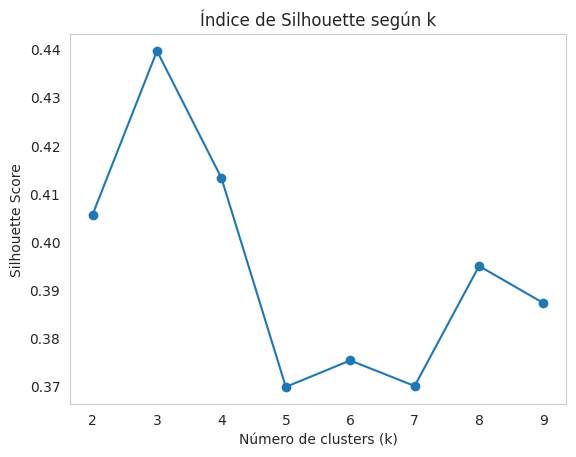

In [155]:
import matplotlib.pyplot as plt

plt.plot(k_range, scores, marker='o')
plt.title("Índice de Silhouette según k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

In [157]:
mlflow.autolog()

with mlflow.start_run(run_name="KMeans - Con métricas") as run:
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    mlflow.log_metrics(
        {
            "Silhouette Score": score
        }
    )

mlflow.autolog(disable=True)

2025/08/04 14:45:33 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/08/04 14:45:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/08/04 14:45:33 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/04 14:45:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/04 14:45:33 WARNING mlflow.utils.autologging_utils: MLflow transformers autologging is known to be compatible with 4.35.2 <= transformers <= 4.51.2, but the installed version is 4.53.2. If you encounter errors during autologging, tr

🏃 View run KMeans - Con métricas at: https://dagshub.com/edynsoncoronado/ml_supervisado_avanzado.mlflow/#/experiments/3/runs/6821a72bd8ce469a80d42ce110089686
🧪 View experiment at: https://dagshub.com/edynsoncoronado/ml_supervisado_avanzado.mlflow/#/experiments/3


In [158]:
print("labels:", set(labels== kmeans.labels_))

labels: {np.True_}


In [159]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
dim_reduction_results = pca.fit_transform(scaled_data)
dim_reduction_results.shape

(1000, 2)

In [160]:
df_dim_redution_results = pd.concat(
  [
    feature_table[["booking_id"]],
    pd.DataFrame(
      dim_reduction_results,
      columns=["dim1", "dim2"]
    ),
    pd.DataFrame(
        kmeans.labels_,
        columns=["cluster"]
    )
  ],
  axis=1
)
df_dim_redution_results.head()

,booking_id,dim1,dim2,cluster
0,76c5a6aa-f7e1-4957-a6d3-db9f2307a7e7,-0.641707,0.626969,1
1,0246660c-ead1-4f0d-ad4a-0bdf4092a315,-1.110092,2.119771,2
2,d3236ae9-d77c-40e8-8922-91a5703ac13a,-4.060739,2.749067,2
3,f01bb250-8087-4614-99b8-207a47c94dde,1.523034,0.563300,0
4,56233e0f-9ae2-4946-90d4-3bf63eaad781,0.611188,0.211711,0


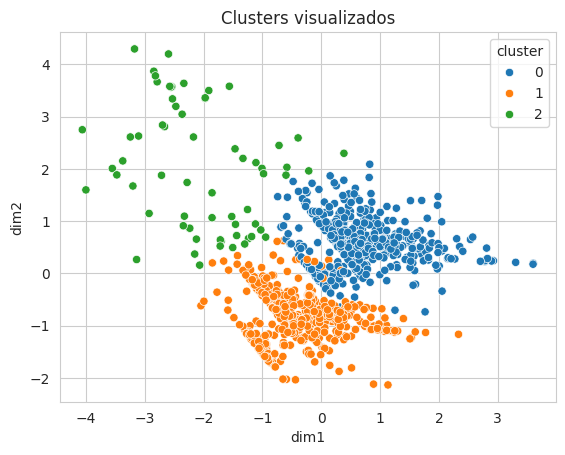

In [161]:
import seaborn as sns
sns.set_style("whitegrid")

sns.scatterplot(x="dim1", y="dim2", data=df_dim_redution_results, hue="cluster",palette="tab10")
plt.title("Clusters visualizados")
plt.show()